<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Musings" data-toc-modified-id="Musings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Musings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Init-anchors,-loss,-mod,-learner" data-toc-modified-id="Init-anchors,-loss,-mod,-learner-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Init anchors, loss, mod, learner</a></span></li><li><span><a href="#Train-Learner" data-toc-modified-id="Train-Learner-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train Learner</a></span><ul class="toc-item"><li><span><a href="#Trained-Models" data-toc-modified-id="Trained-Models-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Trained Models</a></span></li></ul></li><li><span><a href="#Results-and-Metrics" data-toc-modified-id="Results-and-Metrics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results and Metrics</a></span></li></ul></div>

# Summary

Refining previous notebook and experimenting with training. The goal of this nb is to produce an accurate model.

**Journal**
- 2020-11-17 (Tues):
    - Created this nb from a copy of 20201027_coco_C2018_L9 notebook. I want a clean break but also to keep the steps taken in that one (where I moved from "basic" ssd to "moar" and focal loss).
    - Experimented with training models; discovered that loss is a fxn of bs.
    - Last thing I did was train resnet34.
- 2020-12-07 (Mon):
    - Over the past 20 days, I've done quite a bit, but the biggest change is implementing mAP. I might have working code right now, but I'm still testing it.
    - I've had two or three half weeks; progress hasn't felt as fast. I've also picked up a side project for Terry's startup.
    - My current focus is to finish the implementation of mAP so I can compare my results to published ones.

**To do**
- Check tpfpfn's for each im to ensure correctness ✅
- Create fai Metric class version of mAP
- Compare my mAP to published results & SotA
- Create dls inspection function?
- Let show_bb output colored text
- Set all devices in one go

**Small things**
- Change voc to v
- Change ap_calc computation to use learner attrs instead of resultshower attrs

## Musings

**The anchor box approach**

The idea is to subdivide the image into chunks so we can essentially do many single bbox learners instead of one big multibox. To do this, each image must be subdivided into a grid (or multiple grids), and the labels must be remapped to individual grid cells.

Subdivide the image into cells with a grid. For each cell, generate any number of boxes from it so long as those boxes do not have a higher IOU between them and any other grid cell – the generated boxes must be able to be traced back to their grid cell via IOU. For each box generated, have it perform a 'single labeled bbox' task. Each box generated will produce one result. Keep only the most confident results & prune out any that overlap excessively.

# Data

In [ ]:
from fastai.vision.all import *


### Params ###
im_sz   = 224
bs      = 128
val_pct = .10
sub_pct = .05


### Get Items ###
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*sub_pct)]
dls = db.dataloaders(subset, bs=bs)
voc = dls.vocab


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 5499
Size of valid data: 611
batch[0]: 	 torch.float32 	 torch.Size([128, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([128, 43, 4])
batch[2]: 	 torch.int64 	 torch.Size([128, 43])


# Model

In [ ]:
### Architecture ###
def perm(x,k):
    return x.permute(0,3,2,1).contiguous().view(x.size(0),x.size(2)*x.size(3)*k,x.size(1)//k)
class StdConv(Module):
    """(42:00) Wraps together the standard conv2d → batchnorm → dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
class OutConv(Module):
    """Takes nin inputs, outputs two layers: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_acts  = nn.Conv2d(nin, 4*k, 3, padding=1)             
        self.lbl_acts = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1)
        self.lbl_acts.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [perm(self.bb_acts(x), self.k),
                perm(self.lbl_acts(x),self.k)]         
class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module."""
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop  = nn.Dropout(drop)
        self.conv0 = StdConv(512,256, drop=drop) # most grid cells (4x4 for sz=224)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop) # fewest grid cells (1x1 for sz=224)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]
class CustomModule(Module):
    """Simple class for joining a body and a head."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))


### Create Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)
def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1


### mae, BCE_Loss, and FocalLoss ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCELoss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None 
class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    

### iou ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union


### ssd_loss ###
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def get_pred_bbs(act_bb, ancs, anc_sz, device):
    ancs.to(device); anc_sz.to(device)
    acts = torch.tanh(act_bb)                        # make acts between -1 and 1
    ctrs = ancs[:,:2] + (acts[:,:2]/2 * anc_sz) # move ctrs by up to box_size/2
    hws  = ancs[:,2:] * (acts[:,2:]/2+1)          # adjust hw up to 1/2
    return create_anchor_boxes(ctrs, hws)
def map_to_gt(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return bb_idxs, max_iou_per_anc
def ssd_item_loss(act_bbs, act_lbls, bbs, lbls):
    """SSD item loss takes single items from a minibatch, creates hundreds of preds, maps gt
    to the preds, prunes the preds, then calcs & returns the bb and lbl loss for that item."""
    # prep
    bbs,lbls = remove_padding(bbs,lbls)                  # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs, anchors, box_size, 'cuda') # assemble the ~200 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)   # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid) # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                     # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                    # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                        # only include bb preds that overlap w/a gt obj and
    incl = torch.nonzero(high_iou)[:,0]                  # aren't predicting background
    mapped_lbls[~high_iou] = 0                           # assign gt class of bg to preds w/ low max gt iou
    # compute loss
    bb_loss_val  = bb_loss(pred_bbs[incl], mapped_bbs[incl])
    lbl_loss_val = lbl_loss(act_lbls, mapped_lbls)
    return bb_loss_val, lbl_loss_val
def ssd_loss(b_acts, b_bbs, b_lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*b_acts, b_bbs, b_lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o, device=device)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss


### Acts and Targs Utils ###
def nms(boxes, scores, min_iou=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort asc
    idx = idx[-top_k:]       # indices of k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= min_iou
        idx = idx[IoU.le(min_iou)]
    return keep, count
def acts_to_preds(act_bb, act_lbl, ancs, anc_sz, min_iou=.5, min_conf=.2, device='cuda'):
     # convert acts to preds
    pbb = get_pred_bbs(act_bb, ancs, anc_sz, device)
    conf, plbl = act_lbl.sigmoid().max(1)
    # filter out preds w/ nms
    nms_idxs, nms_n = nms(pbb.data, conf, min_iou)
    nms_idxs = nms_idxs[:nms_n]
    pbb  = pbb[nms_idxs]
    plbl = plbl[nms_idxs]
    conf = conf[nms_idxs]
    # filter out bg and low-conf preds
    is_not_bg = (plbl!=0)
    is_confident = conf > min_conf
    mask = is_not_bg & is_confident
    return pbb[mask], plbl[mask], conf[mask]
def get_batch_preds(abb, albl, ancs, anc_sz, device='cuda'):
    ancs.to(device); anc_sz.to(device)
    pbbs, plbls, confs = [], [], []
    for abb, albl in zip(abb, albl):
        pbb, plbl, conf = acts_to_preds(abb, albl, ancs, anc_sz, device=device)
        pbbs  += [pbb]
        plbls += [plbl]
        confs += [conf]
    return pbbs, plbls, confs

In [ ]:
### Metric ###
def _format_inps(acts, targs, anchors, box_size):
    """Format acts and targs for AP score calc. Input expects learner.acts & learner.batch,
       output format: (im_idx, pred_bbs, pred_cls, cls_conf) and (im_idx, bbs, cls).
       Ex: (46.0, tensor([0.1, 0.2, 0.9, 0.9]), tensor(3), tensor(0.78))"""
    preds = get_batch_preds(*acts, anchors, box_size)
    pred_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])])
    pred_idxs = pred_idxs.numpy().tolist()
    gt_idxs   = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(targs[1])])
    gt_idxs   = gt_idxs.numpy().tolist()
    batch_preds = list(zip(pred_idxs, *[torch.cat(o) for o in preds]))
    batch_gts   = list(zip(gt_idxs,   *[o.flatten(end_dim=1) for o in targs[1:]]))
    return batch_preds, batch_gts
def _flatten_list(l, ret_L=False):
    """Flatten a list-of-lists; lists can be python `list`s or a fastai `L`s."""
    def _recur(l,res):
        for o in l:
            if   isinstance(o,list): _recur(o,res)
            elif isinstance(o,L)   : _recur(o,res)
            else: res.append(o)
        return res
    res = _recur(l, [])
    return res if not ret_L else L(res)
def _get_tp_bbs(preds_tp):
    """Output list of tp bbs per im in batch. Not used to calculate mAP; only
       used to grab true positive bb preds for visualizing in ResultShower."""
    
    # Each row in preds_tps is a formatted pred (see format_ap_inputs) and a list of
    # 1s and 0s (signifying tps and fps) for a cls. No preds for a cls → empty lists.
    
    batch_idxs, pred_bbs, tpfps = [], [], []
    for preds,tp in preds_tp:
        batch_idxs.append([o[0] for o in preds])
        pred_bbs.append([o[1] for o in preds])
        tpfps.append(tp)
    flat_idxs  = _flatten_list(batch_idxs)
    flat_bbs   = _flatten_list(pred_bbs)
    flat_tpfps = torch.cat(tpfps)

    scored_preds = list(zip(flat_idxs, flat_bbs, flat_tpfps))
    true_bbs = [(int(o[0]), o[1]) for o in scored_preds if o[2]==True]

    true_preds = [torch.zeros(4).view(1,4) for i in range(0,bs)]
    for i,bb in true_bbs:
        if true_preds[i].sum()==0: true_preds[i] = bb.view(1,4)
        else: true_preds[i] = torch.cat([true_preds[int(i)], bb.view(1,4)], dim=0)
    return true_preds
def ap_per_cls(acts, target, n_cls, ancs, anc_sz, iou_thresh=.5, device='cuda'):
    """Calculate AP score per class."""
    batch_preds, batch_gts = _format_inps(acts, target, ancs.to(device), anc_sz.to(device))
    
    avg_precs = [] # accumulator for AP score of each class
    preds_tp = [] # not used in AP calc; used to viz tp_bbs
    n_objs_accum = [] # not used in AP calc; for finging n false negs per im
    for c in range(1,n_cls+1):
        # store preds and gts for current cls
        preds = [b for b in batch_preds if b[2]==c]
        gts   = [b for b in batch_gts   if b[2]==c]
                
        # sort preds by conf desc
        preds.sort(key=lambda x: x[3], reverse=True)
        
        # make dict of im_idx:zeros(n_objs)
        n_objs = Counter([gt[0] for gt in gts])
        for k,v in n_objs.items(): n_objs[k] = torch.zeros(v)
        
        # init tp: a bool tensor for each im s.t. 1s indicate a pred is a tp
        tp = torch.zeros((len(preds))).bool()
        total_gt_objs = len(gts)
        
        for pred_idx, pred in enumerate(preds):
            gt_objs = [o for o in gts if o[0] == pred[0]]
            n_gt_objs = len(gt_objs)
            max_iou = 0
            
            for idx, gt in enumerate(gt_objs):
                iou = get_iou(pred[1].view(1,4), gt[1].view(1,4))
                if iou > max_iou: max_iou, idx_of_max = iou, idx
                    
            # update idx of gt_obj to indicate it's been used
            if max_iou > iou_thresh:
                if n_objs[pred[0]][idx_of_max]==0:
                    tp[pred_idx] = 1
                    n_objs[pred[0]][idx_of_max] = 1
                    
        # store tp_bbs: use tp ask mask on preds and take 1th item (the bb) from each
        preds_tp.append(([preds,tp]))
        n_objs_accum.append(n_objs)
        
        # calc avg_prec and store
        tps = torch.cumsum(tp, dim=0)               # 1. tp csum: [0,1,1,0,0] → [0,1,2,2,2]
        fps = torch.cumsum(~tp, dim=0)              # (basically same steps for fp)
        prec = torch.div(tps, (tps + fps + 1e-6))   # 2. divide each tps item by n_preds
        prec = torch.cat((torch.tensor([1]), prec)) # 3. slap on a 1 at the beginning
        rec = tps / (total_gt_objs + 1e-6)
        rec = torch.cat((torch.tensor([0]), rec))
        avg_prec = torch.trapz(prec, rec) # calc AP w/ trap rule
        avg_precs.append(avg_prec)        # store AP of this cls in accum
    return sum(avg_precs)/len(avg_precs)
def get_metric(acts, target, n_cls, ancs, anc_sz, iou_thresh=.5, device='cuda'):
    """Calculate AP score per class."""
    batch_preds, batch_gts = _format_inps(acts, target, ancs.to(device), anc_sz.to(device))
    
    avg_precs = [] # accumulator for AP score of each class
    preds_tp = [] # not used in AP calc; used to viz tp_bbs
    n_objs_accum = [] # not used in AP calc; for finging n false negs per im
    for c in range(1,n_cls+1):
        # store preds and gts for current cls
        preds = [b for b in batch_preds if b[2]==c]
        gts   = [b for b in batch_gts   if b[2]==c]
                
        # sort preds by conf desc
        preds.sort(key=lambda x: x[3], reverse=True)
        
        # make dict of im_idx:zeros(n_objs)
        n_objs = Counter([gt[0] for gt in gts])
        for k,v in n_objs.items(): n_objs[k] = torch.zeros(v)
        
        # init tp: a bool tensor for each im s.t. 1s indicate a pred is a tp
        tp = torch.zeros((len(preds))).bool()
        total_gt_objs = len(gts)
        
        for pred_idx, pred in enumerate(preds):
            gt_objs = [o for o in gts if o[0] == pred[0]]
            n_gt_objs = len(gt_objs)
            max_iou = 0
            
            for idx, gt in enumerate(gt_objs):
                iou = get_iou(pred[1].view(1,4), gt[1].view(1,4))
                if iou > max_iou: max_iou, idx_of_max = iou, idx
                    
            # update idx of gt_obj to indicate it's been used
            if max_iou > iou_thresh:
                if n_objs[pred[0]][idx_of_max]==0:
                    tp[pred_idx] = 1
                    n_objs[pred[0]][idx_of_max] = 1
                    
        # store tp_bbs: use tp ask mask on preds and take 1th item (the bb) from each
        preds_tp.append(([preds,tp]))
        n_objs_accum.append(n_objs)
        
        # calc avg_prec and store
        tps = torch.cumsum(tp, dim=0)               # 1. tp csum: [0,1,1,0,0] → [0,1,2,2,2]
        fps = torch.cumsum(~tp, dim=0)              # (basically same steps for fp)
        prec = torch.div(tps, (tps + fps + 1e-6))   # 2. divide each tps item by n_preds
        prec = torch.cat((torch.tensor([1]), prec)) # 3. slap on a 1 at the beginning
        rec = tps / (total_gt_objs + 1e-6)
        rec = torch.cat((torch.tensor([0]), rec))
        avg_prec = torch.trapz(prec, rec) # calc AP w/ trap rule
        avg_precs.append(avg_prec)        # store AP of this cls in accum
    return avg_precs, _get_tp_bbs(preds_tp), n_objs_accum

In [ ]:
### show_bb and ResultShower ##
def show_bb(im, bb=None, lbl=[''], sz=im_sz, figsz=5, color='white', ctx=None, title=None):
    # process empties and nones
    if bb.shape[-1]==0 or bb==None: bb  = tensor([[0.,0,0,0]])
    if lbl==['']:                   lbl = ['']*bb.shape[0]
        
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:     show_image(im, figsize=[figsz,figsz], title=title, ctx=ctx)
    else: ctx = show_image(im, figsize=[figsz,figsz], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        # store init's args
        self.dls    = dls
        self.mod    = lrn.model.eval()
        self.ancs   = ancs.cpu()
        self.anc_sz = anc_sz.cpu()
        # compute attributes
        self.batch    = next(iter(self.dls.cpu().valid))
        self.acts     = [a.data for a in self.mod.cpu()(self.batch[0])]
        self.preds    = get_batch_preds(*self.acts, self.ancs, self.anc_sz, device='cpu')
        self.dec_ims  = self.dls.decode(self.batch)[0]
        self.im_sz    = self.batch[0].shape[-1]
        self.v        = self.dls.vocab
        self.last_res = 0
        self.figsize  = [12,12]
        # compute metrics
        self.ap_scores,self.tp_bbs,self.nobj = get_metric(self.acts,self.batch,len(self.v),self.ancs,self.anc_sz,device='cpu')
        # clean up
        self.dls.cuda(); self.mod.cuda()
        
    def __call__(self, *args, **kwargs):
        return self.show_next(*args, **kwargs)
    
    def __getitem__(self, i):
        # get everything to draw
        _,bbs,lbls      = self.batch
        pbbs,plbls,conf = self.preds
        tbbs            = self.tp_bbs
        ims             = self.dec_ims
        # draw
        ctx = get_grid(2, figsize=self.figsize)
        show_bb(ims[i], bbs[i],   self.v[lbls[i]],  sz=self.im_sz, ctx=ctx[0]);
        show_bb(ims[i], pbbs[i],  self.v[plbls[i]], sz=self.im_sz, ctx=ctx[1], color='magenta');
        show_bb(ims[i], tbbs[i],                    sz=self.im_sz, ctx=ctx[1], color='lime')
                 
    def show_next(self, n=1):
        for i in range(n): self[i + self.last_res]
        self.last_res += n

Time to make a fastai Metric for mAP! IIRC:
- reset runs at the beginning of every epoch
- accumulate runs at the beginning of every mini-batch
- value runs at the end of every epoch

The idea is to accumulate a metric for each batch, then average them at the end of each epoch.

Pct / Epochs / Score:
- 5% / 5 / .0022

In [ ]:
class MeanAveragePrecision(Metric):
    
    def __init__(self, func): self.func = func
    
    @property
    def name(self): return "mAP"
        
    def reset(self, learn):
        self.res = []
        
    def accumulate(self, learn):
    # store results of each minibatch
        self.res.append(1)
        
    @property
    def value(self):
        return sum(self.res)/len(self.res)

met = MeanAveragePrecision(ap_per_cls)

# Init anchors, loss, mod, learner

In [ ]:
# init ancs
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# init learner
bb_loss = mae
lbl_loss = FocalLoss(len(dls.vocab))
mod = CustomModule(create_body(resnet34, pretrained=True), SSDHead(k, -4., drop=.4))
learner = Learner(dls, mod, loss_func=ssd_loss) #, metrics=met)

# train
learner.freeze()

# Train Learner

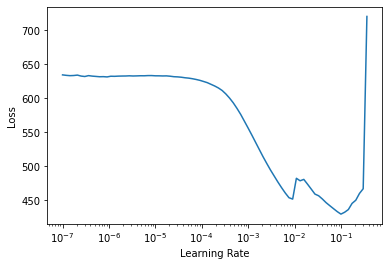

In [ ]:
lr_min,lr_max = learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, lr=3e-3) #(lr_min+lr_max)/2

epoch,train_loss,valid_loss,time
0,342.231628,172.098557,00:25
1,218.402420,150.980103,00:25
2,175.223709,136.223053,00:25
3,150.323685,127.835068,00:25
4,135.772293,125.647552,00:25


In [ ]:
batch = next(iter(learner.dls.valid))

device(type='cuda', index=0)

In [ ]:
acts = learner.model.eval()(batch[0])

In [ ]:
preds = get_batch_preds(*acts, anchors, box_size)

In [ ]:
ap_per_cls(acts, batch, len(voc), anchors, box_size, device='cuda')

tensor(0.0022)

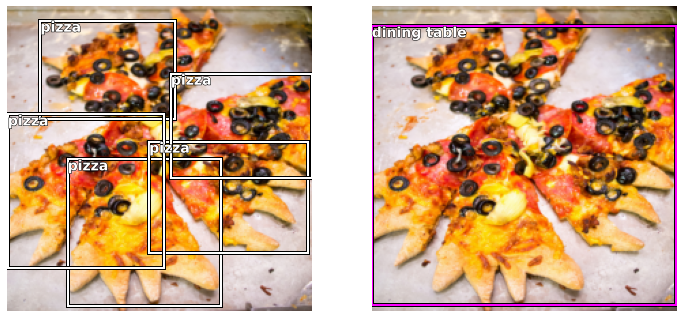

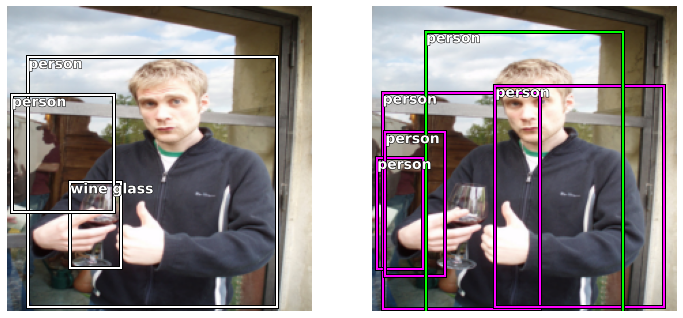

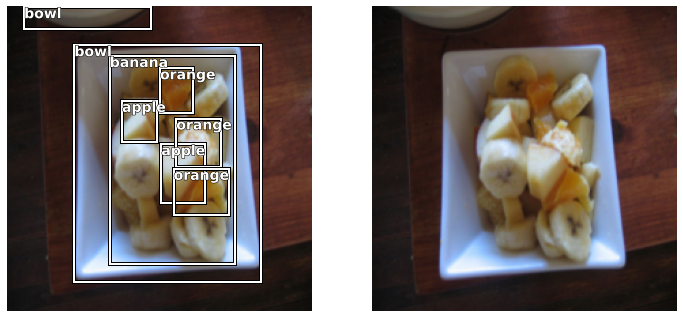

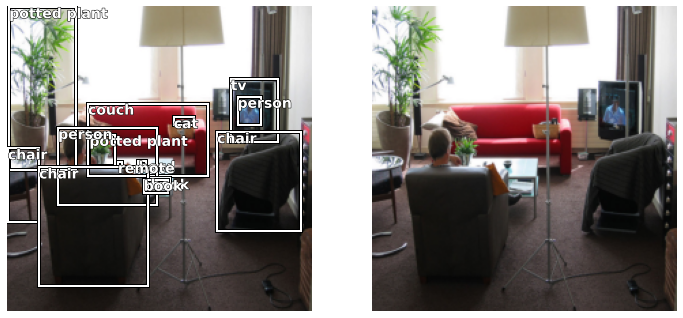

In [ ]:
results = ResultShower(learner.dls, learner, anchors, box_size)
results(4)

In [ ]:
# learner.export('models/20201117_coco_ssd_resnet34_50pct.pkl')

# learner.save('s1')

# learner.final_record[1]/bs

## Trained Models

2020-11-16
- `'models/20201116_coco_ssd_moar_53.pkl'`
    - valid loss: 53
    - 5 epochs with one layer frozen
    - lr: 2e-3
    - first time trained with perm instead of flatten_loss
- `'models/20201116_coco_focal_47.pkl'`
    - valid loss: 47
    - 5 epochs with two layers frozen
    - lr: 3e-3
    - first time trained with perm instead of flatten_loss
    - deep trained to produce the following model (didn't improve results)

2020-11-17
- **Baseline: resnet34 w/ 10% of data**
    - valid_loss = 100
    - fit_one_cycle(10, lr=2e-3)
    - 48s per epoch
    - resnet34
    - dls.n_cls = 36
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
    - Exported to `models/20201117_coco_ssdfocal_0.pkl`
    - Note: my attempts to unfreeze and train further have been unsuccessful
    - vl/bs = .781
- **xresnet34 w/ 10% of data**
    - Summary
        - Testing **xresnet34** vs the baseline
        - Result: similar or possibly worse
        - valid_loss = 113
    - Training
        - fit_one_cycle(10, lr=3e-3)
        - 52s per epoch
    - Data
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
        - n_cls = 38
- **xresnet34 w/ 20% of data**
    - valid_loss = 111
    - fit_one_cycle(5, lr=3e-3)
    - 1:40 per epoch (wasn't it taking 2:40 earlier? is this due to batch size?)
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = **.2**
- **resnet34 w/ 10% of data & bs=64**
    - I'm running this to see if I get better results than the baseline with a lower bs
        - Oh baby, I'm getting a lower loss, but I see now that *loss sums over the batch!* Lower bs will almost always have lower loss.
        - For example, the starting valid loss is 80, which is exactly half of the starting loss from the sessions with a larger bs.
        - I need a metric! I suppose I can use valid_loss/bs for now?
    - valid_loss = 53
    - fit_one_cycle(5, lr=3e-3) 
    - data params
        - im_sz   = 224
        - bs      = **64**
        - val_pct = .10
        - sub_pct = .10
- **resnet34 fine_tune**
    - Testing fine_tune vs fit_one_cycle. I expect fine_tune to outperform.
    - Result: fine_tune did not improve the result and required an additional epoch to match the above model's loss.
    - valid_loss = 54
    - **fine_tune**(3, freeze_epochs=3, lr=slice(lr/100,lr))
    - data params
        - im_sz   = 224
        - bs      = 64
        - val_pct = .10
        - sub_pct = .10
- **resnet34 w/ 50% of data**
    - Let's see how much more data helps the result.
    - Result: 88
        - best valid_loss on 7th epoch (vl = 86)
        - started overfitting on 8th epoch (vl = 87)
    - vl/bs = .685
    - fit_one_cycle(10, lr=(lr_min+lr_max)/2)
    - 227s per epoch
    - lr = 3.6e-3
    - data params
        - im_sz   = 224
        - bs      = 128
        - val_pct = .10
        - sub_pct = **.50**
    - Exported to `models/20201117_coco_ssd_resnet34_50pct.pkl`

# Results and Metrics

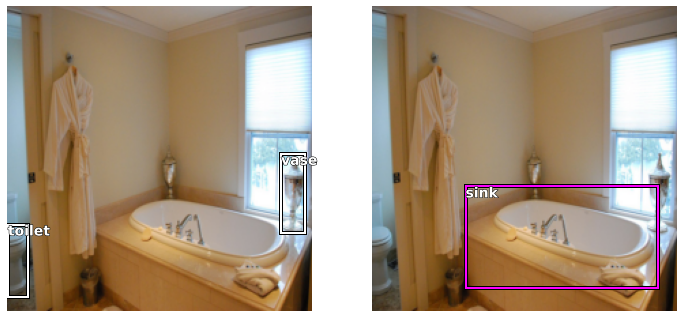

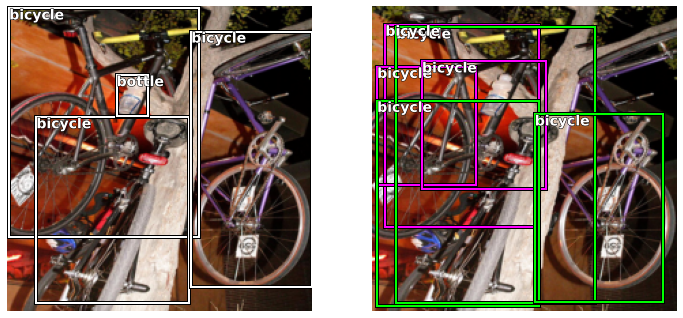

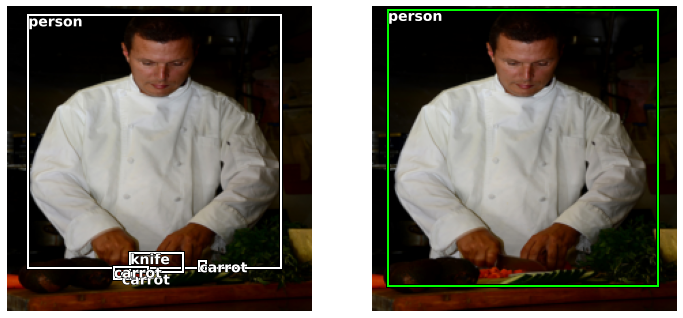

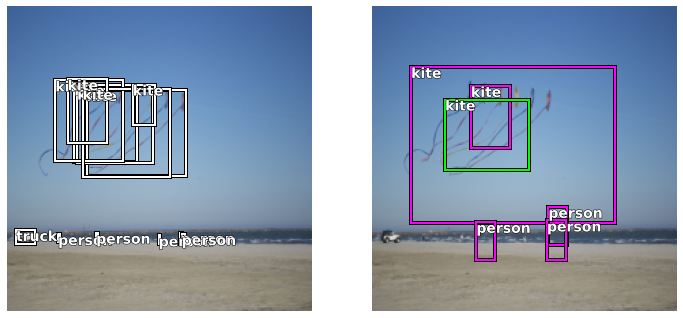

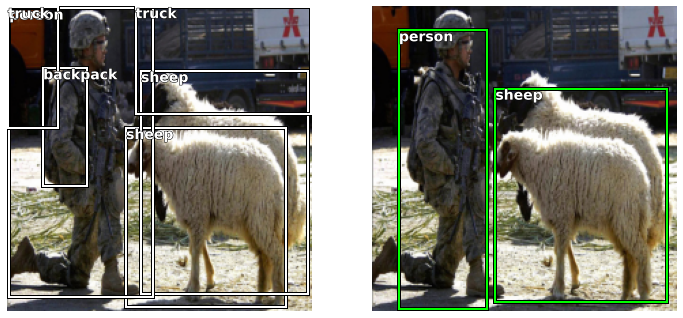

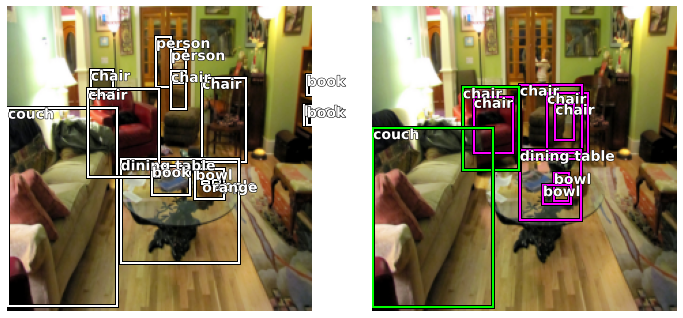

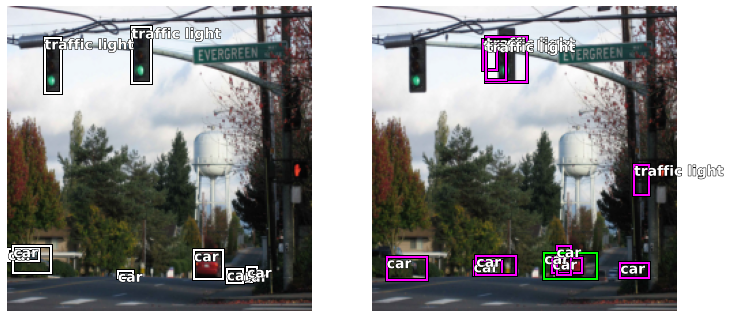

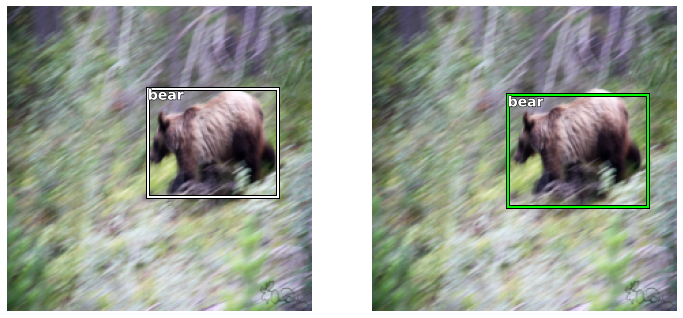

In [ ]:
learner50 = load_learner('models/20201117_coco_ssd_resnet34_50pct.pkl')
res50 = ResultShower(dls, learner50, anchors, box_size)
res50(3)

Looking at TPs, FPs, and FNs per im.

In [ ]:
# tps
tps = []
for bbs in res50.tp_bbs:
    if bbs.sum()==0: tps.append(0)
    else: tps.append(bbs.shape[0])
#fps
preds_per_im = [o.shape[0] for o in res50.preds[0]]
preds_per_im
fps = [pred-tp for pred,tp in zip(preds_per_im, tps)]
# fns
im_dict = defaultdict(lambda: [])
for cls in res50.nobj:
    for im_idx,tp_tensor in cls.items():
        im_dict[im_idx] += ~tp_tensor.bool()
idx_fns = [(k,sum(v).item()) for k,v in im_dict.items()]
idx_fns.sort()
fns = [o[1] for o in idx_fns]
# together
tpfpfns = list(zip(tps,fps,fns))
tpfpfns

[(0, 1, 2),
 (3, 3, 1),
 (1, 0, 4),
 (1, 5, 12),
 (2, 0, 4),
 (2, 7, 13),
 (1, 10, 8),
 (1, 0, 0),
 (1, 3, 8),
 (1, 1, 0),
 (2, 1, 0),
 (3, 23, 23),
 (1, 11, 13),
 (1, 0, 2),
 (1, 0, 1),
 (2, 13, 27),
 (1, 0, 1),
 (1, 2, 4),
 (1, 1, 1),
 (1, 0, 1),
 (0, 1, 3),
 (3, 2, 0),
 (1, 2, 4),
 (2, 6, 13),
 (1, 2, 5),
 (1, 2, 1),
 (3, 4, 4),
 (3, 7, 3),
 (2, 10, 16),
 (1, 2, 3),
 (1, 0, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 0, 2),
 (1, 1, 3),
 (3, 13, 16),
 (0, 1, 1),
 (0, 0, 3),
 (1, 0, 1),
 (2, 12, 29),
 (1, 1, 1),
 (1, 0, 2),
 (1, 1, 1),
 (1, 8, 7),
 (2, 6, 10),
 (1, 15, 26),
 (1, 9, 11),
 (0, 5, 1),
 (0, 6, 7),
 (1, 0, 1),
 (2, 1, 0),
 (0, 3, 7),
 (1, 3, 1),
 (1, 2, 3),
 (0, 0, 1),
 (1, 6, 8),
 (3, 3, 5),
 (1, 14, 14),
 (1, 1, 1),
 (1, 3, 9),
 (1, 4, 2),
 (2, 2, 2),
 (0, 6, 12),
 (1, 7, 6),
 (0, 7, 8),
 (0, 1, 2),
 (0, 2, 3),
 (2, 0, 1),
 (2, 0, 0),
 (2, 1, 4),
 (3, 15, 16),
 (0, 1, 2),
 (1, 4, 1),
 (0, 5, 9),
 (1, 0, 0),
 (0, 4, 11),
 (4, 8, 9),
 (0, 5, 6),
 (1, 0, 0),
 (0, 5, 4),
 (3, 20, 14),


In [ ]:
lrn = load_learner('models/20201117_coco_ssd_resnet34_50pct.pkl')

In [ ]:
lrn.dls = dls.cuda()
batch   = next(iter(lrn.dls.valid))
acts    = [a.data for a in lrn.model.eval()(batch[0])]
preds   = get_batch_preds(*acts, anchors, box_size)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
ap_per_cls(acts, batch, len(voc), anchors, box_size, cuda=True)